In [1]:
from pyspark.sql import SparkSession
import os
import tempfile
import urllib.request

# Create Spark session
spark = SparkSession.builder \
    .master("local[*]") \
    .appName("random-forest") \
    .getOrCreate()

# Correct raw GitHub URL and safe local path (no leading slash in filename)
url = "https://raw.githubusercontent.com/Apress/machine-learning-with-pyspark/master/chapter_6_Random_Forests/affairs.csv"
local_path = os.path.join(tempfile.gettempdir(), "Log_Reg_dataset.csv")

# Download dataset (overwrites if already present)
urllib.request.urlretrieve(url, local_path)

# Read with Spark
df = spark.read.csv(local_path, header=True, inferSchema=True)

# Quick sanity check
print(f"Loaded file: {local_path} (exists={os.path.exists(local_path)})")
df.show(5)

Loaded file: /tmp/Log_Reg_dataset.csv (exists=True)
+-------------+----+-----------+--------+---------+-------+
|rate_marriage| age|yrs_married|children|religious|affairs|
+-------------+----+-----------+--------+---------+-------+
|            5|32.0|        6.0|     1.0|        3|      0|
|            4|22.0|        2.5|     0.0|        2|      0|
|            3|32.0|        9.0|     3.0|        3|      1|
|            3|27.0|       13.0|     3.0|        1|      1|
|            4|22.0|        2.5|     0.0|        1|      1|
+-------------+----+-----------+--------+---------+-------+
only showing top 5 rows


In [2]:
df.printSchema()

root
 |-- rate_marriage: integer (nullable = true)
 |-- age: double (nullable = true)
 |-- yrs_married: double (nullable = true)
 |-- children: double (nullable = true)
 |-- religious: integer (nullable = true)
 |-- affairs: integer (nullable = true)



In [3]:
df.count(), df.columns

(6366,
 ['rate_marriage', 'age', 'yrs_married', 'children', 'religious', 'affairs'])

In [4]:
df.describe().show()

+-------+------------------+------------------+-----------------+------------------+------------------+------------------+
|summary|     rate_marriage|               age|      yrs_married|          children|         religious|           affairs|
+-------+------------------+------------------+-----------------+------------------+------------------+------------------+
|  count|              6366|              6366|             6366|              6366|              6366|              6366|
|   mean| 4.109644989004084|29.082862079798932| 9.00942507068803|1.3968740182218033|2.4261702796104303|0.3224945020420987|
| stddev|0.9614295945655025| 6.847881883668817|7.280119972766412| 1.433470828560344|0.8783688402641785| 0.467467779921086|
|    min|                 1|              17.5|              0.5|               0.0|                 1|                 0|
|    max|                 5|              42.0|             23.0|               5.5|                 4|                 1|
+-------+-------

In [5]:
df.groupBy("affairs").count().show()

+-------+-----+
|affairs|count|
+-------+-----+
|      1| 2053|
|      0| 4313|
+-------+-----+



In [7]:
df.groupBy("rate_marriage").count().sort("rate_marriage").show()

+-------------+-----+
|rate_marriage|count|
+-------------+-----+
|            1|   99|
|            2|  348|
|            3|  993|
|            4| 2242|
|            5| 2684|
+-------------+-----+



In [8]:
df.groupBy('rate_marriage', 'affairs').count().sort('rate_marriage', 'affairs', 'count', ascending = True).show()

+-------------+-------+-----+
|rate_marriage|affairs|count|
+-------------+-------+-----+
|            1|      0|   25|
|            1|      1|   74|
|            2|      0|  127|
|            2|      1|  221|
|            3|      0|  446|
|            3|      1|  547|
|            4|      0| 1518|
|            4|      1|  724|
|            5|      0| 2197|
|            5|      1|  487|
+-------------+-------+-----+



In [10]:
df.groupBy('religious', 'affairs').count().sort('religious', 'affairs', 'count', ascending = True).show()

+---------+-------+-----+
|religious|affairs|count|
+---------+-------+-----+
|        1|      0|  613|
|        1|      1|  408|
|        2|      0| 1448|
|        2|      1|  819|
|        3|      0| 1715|
|        3|      1|  707|
|        4|      0|  537|
|        4|      1|  119|
+---------+-------+-----+



In [11]:
df.groupBy('children', 'affairs').count().sort('children', 'affairs', 'count', ascending = True).show()

+--------+-------+-----+
|children|affairs|count|
+--------+-------+-----+
|     0.0|      0| 1912|
|     0.0|      1|  502|
|     1.0|      0|  747|
|     1.0|      1|  412|
|     2.0|      0|  873|
|     2.0|      1|  608|
|     3.0|      0|  460|
|     3.0|      1|  321|
|     4.0|      0|  197|
|     4.0|      1|  131|
|     5.5|      0|  124|
|     5.5|      1|   79|
+--------+-------+-----+



In [12]:
df.groupBy("affairs").mean().show()

+-------+------------------+------------------+------------------+------------------+------------------+------------+
|affairs|avg(rate_marriage)|          avg(age)|  avg(yrs_married)|     avg(children)|    avg(religious)|avg(affairs)|
+-------+------------------+------------------+------------------+------------------+------------------+------------+
|      1|3.6473453482708234|30.537018996590355|11.152459814905017|1.7289332683877252| 2.261568436434486|         1.0|
|      0| 4.329700904242986| 28.39067934152562| 7.989334569904939|1.2388128912589844|2.5045212149316023|         0.0|
+-------+------------------+------------------+------------------+------------------+------------------+------------+



In [13]:
from pyspark.ml.feature import VectorAssembler

In [14]:
df_assembler = VectorAssembler(
    inputCols=['rate_marriage', 'age', 'yrs_married', 'children', 'religious'],
    outputCol='features')

df = df_assembler.transform(df)

df.printSchema()

root
 |-- rate_marriage: integer (nullable = true)
 |-- age: double (nullable = true)
 |-- yrs_married: double (nullable = true)
 |-- children: double (nullable = true)
 |-- religious: integer (nullable = true)
 |-- affairs: integer (nullable = true)
 |-- features: vector (nullable = true)



In [15]:
df.select('features', 'affairs').show(5, truncate=False)

+-----------------------+-------+
|features               |affairs|
+-----------------------+-------+
|[5.0,32.0,6.0,1.0,3.0] |0      |
|[4.0,22.0,2.5,0.0,2.0] |0      |
|[3.0,32.0,9.0,3.0,3.0] |1      |
|[3.0,27.0,13.0,3.0,1.0]|1      |
|[4.0,22.0,2.5,0.0,1.0] |1      |
+-----------------------+-------+
only showing top 5 rows


In [16]:
model_df = df.select('features', 'affairs')

In [17]:
train_df, test_df = model_df.randomSplit([0.75, 0.25], seed=42)

train_df.count(), test_df.count()

(4840, 1526)

In [18]:
train_df.groupBy('affairs').count().show(), test_df.groupBy('affairs').count().show()

+-------+-----+
|affairs|count|
+-------+-----+
|      1| 1563|
|      0| 3277|
+-------+-----+

+-------+-----+
|affairs|count|
+-------+-----+
|      1|  490|
|      0| 1036|
+-------+-----+



(None, None)

In [19]:
from pyspark.ml.classification import RandomForestClassifier

rf_classifier = RandomForestClassifier(labelCol='affairs', featuresCol='features', numTrees=50).fit(train_df)

In [21]:
rf_predictions = rf_classifier.transform(test_df)

rf_predictions.show()

+--------------------+-------+--------------------+--------------------+----------+
|            features|affairs|       rawPrediction|         probability|prediction|
+--------------------+-------+--------------------+--------------------+----------+
|[1.0,22.0,2.5,0.0...|      1|[17.8470485032684...|[0.35694097006536...|       1.0|
|[1.0,22.0,2.5,1.0...|      0|[17.5449761077126...|[0.35089952215425...|       1.0|
|[1.0,22.0,2.5,1.0...|      1|[17.5449761077126...|[0.35089952215425...|       1.0|
|[1.0,22.0,2.5,1.0...|      0|[17.5295845745339...|[0.35059169149067...|       1.0|
|[1.0,27.0,2.5,0.0...|      1|[16.5990985421340...|[0.33198197084268...|       1.0|
|[1.0,27.0,6.0,1.0...|      0|[16.7102627078064...|[0.33420525415612...|       1.0|
|[1.0,27.0,6.0,2.0...|      1|[16.5165405224833...|[0.33033081044966...|       1.0|
|[1.0,27.0,13.0,2....|      1|[15.4242980475882...|[0.30848596095176...|       1.0|
|[1.0,32.0,2.5,1.0...|      0|[23.1828828524280...|[0.46365765704856...|    

In [23]:
rf_predictions.groupBy('prediction').count().show()

+----------+-----+
|prediction|count|
+----------+-----+
|       0.0| 1251|
|       1.0|  275|
+----------+-----+



In [24]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.evaluation import BinaryClassificationEvaluator

In [25]:
rf_accuracy = MulticlassClassificationEvaluator(labelCol='affairs', predictionCol='prediction', metricName='accuracy').evaluate(rf_predictions)

print(f"Random Forest Classifier Accuracy: {rf_accuracy:.4f}")

Random Forest Classifier Accuracy: 0.7149


In [26]:
rf_precision = MulticlassClassificationEvaluator(labelCol='affairs', predictionCol='prediction', metricName='weightedPrecision').evaluate(rf_predictions)

print(f"Random Forest Classifier Precision: {rf_precision:.4f}")

Random Forest Classifier Precision: 0.6952


In [27]:
rf_auc = BinaryClassificationEvaluator(labelCol='affairs', rawPredictionCol='rawPrediction', metricName='areaUnderROC').evaluate(rf_predictions)

print(f"Random Forest Classifier AUC: {rf_auc:.4f}")

Random Forest Classifier AUC: 0.7285


In [28]:
rf_classifier.featureImportances

SparseVector(5, {0: 0.6236, 1: 0.0226, 2: 0.2315, 3: 0.0584, 4: 0.0638})

In [30]:
df.schema["features"].metadata["ml_attr"]["attrs"]['numeric']

[{'name': 'rate_marriage', 'idx': 0},
 {'name': 'age', 'idx': 1},
 {'name': 'yrs_married', 'idx': 2},
 {'name': 'children', 'idx': 3},
 {'name': 'religious', 'idx': 4}]

In [31]:
from pyspark.ml.classification import RandomForestClassificationModel

rf_classifier.save("rf_classifier_model")

loaded_rf_classifier = RandomForestClassificationModel.load("rf_classifier_model")

In [33]:
new_rf_predictions = loaded_rf_classifier.transform(test_df)
new_rf_predictions.show()

+--------------------+-------+--------------------+--------------------+----------+
|            features|affairs|       rawPrediction|         probability|prediction|
+--------------------+-------+--------------------+--------------------+----------+
|[1.0,22.0,2.5,0.0...|      1|[17.8470485032684...|[0.35694097006536...|       1.0|
|[1.0,22.0,2.5,1.0...|      0|[17.5449761077126...|[0.35089952215425...|       1.0|
|[1.0,22.0,2.5,1.0...|      1|[17.5449761077126...|[0.35089952215425...|       1.0|
|[1.0,22.0,2.5,1.0...|      0|[17.5295845745339...|[0.35059169149067...|       1.0|
|[1.0,27.0,2.5,0.0...|      1|[16.5990985421340...|[0.33198197084268...|       1.0|
|[1.0,27.0,6.0,1.0...|      0|[16.7102627078064...|[0.33420525415612...|       1.0|
|[1.0,27.0,6.0,2.0...|      1|[16.5165405224833...|[0.33033081044966...|       1.0|
|[1.0,27.0,13.0,2....|      1|[15.4242980475882...|[0.30848596095176...|       1.0|
|[1.0,32.0,2.5,1.0...|      0|[23.1828828524280...|[0.46365765704856...|    

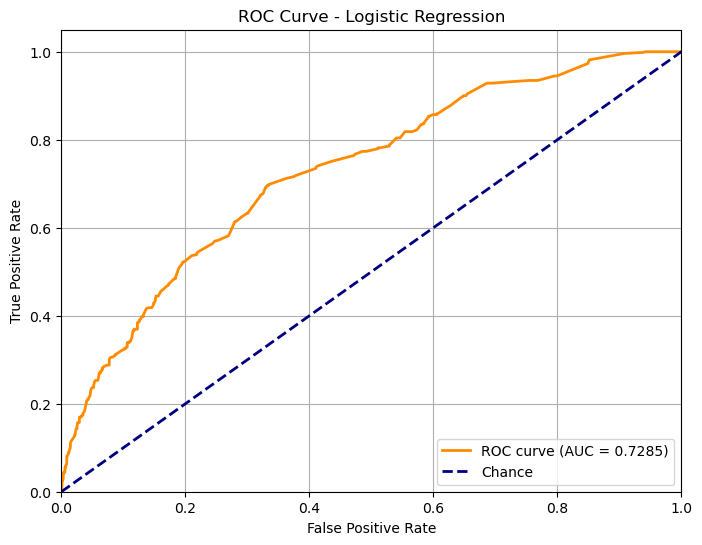

In [34]:
import pandas as pd
from sklearn.metrics import roc_curve, auc

import matplotlib.pyplot as plt

# extract probability for the positive class and labels from the Spark DataFrame
rows = new_rf_predictions.select("probability", "affairs").rdd.map(lambda r: (float(r['probability'][1]), int(r['affairs']))).collect()
pdf = pd.DataFrame(rows, columns=["prob", "label"])

# compute ROC curve and AUC
fpr, tpr, _ = roc_curve(pdf["label"], pdf["prob"])
roc_auc = auc(fpr, tpr)

# plot
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"ROC curve (AUC = {roc_auc:.4f})")
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--", label="Chance")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Logistic Regression")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

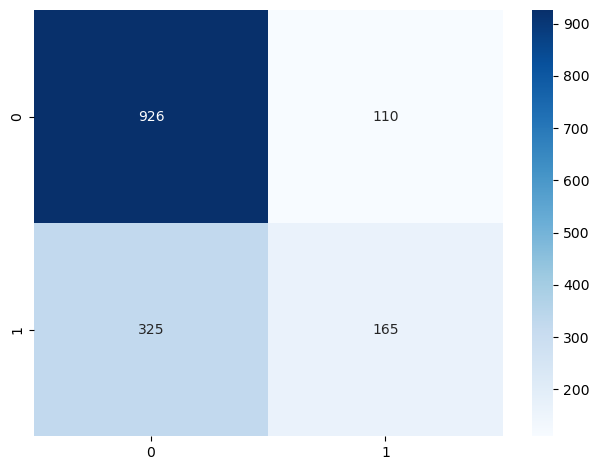

In [41]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

# get predictions and true labels from the Spark DataFrame
preds_df = new_rf_predictions.select("prediction", "affairs").toPandas()
y_true = preds_df["affairs"].astype(int)
y_pred = preds_df["prediction"].astype(int)

# compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# plot raw counts and normalized matrix side-by-side

sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")

plt.tight_layout()
plt.show()